In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

## Question 1

In [2]:
#func to define params for problem 1
def get_airline_params():
    return {
        'coach_seats': 100,
        'first_class_seats': 20,
        'days_until_takeoff': 365,
        'coach_prices': [300, 350],
        'first_class_prices': [425, 500],
        'coach_sale_prob': {300: 0.65, 350: 0.30},
        'coach_sale_prob_fc_sold_out': {300: 0.68, 350: 0.33},
        'first_class_sale_prob': {425: 0.08, 500: 0.04},
        'coach_show_prob': 0.95,
        'first_class_show_prob': 0.97,
        'cost_bump_to_first_class': 50,
        'cost_bump_off_plane': 425,
        'annual_discount_rate': 0.17
    }


In [3]:
#func to define discount factor
def get_discount_factor(annual_rate):
    return 1 / (1 + annual_rate / 365)

In [4]:
#func to calculate terminal condition
def calculate_terminal_costs(V, max_coach_tickets, first_class_seats, coach_show_prob, 
                             first_class_show_prob, coach_seats, cost_bump_to_fc, cost_bump_off):
    for coach_sold in range(max_coach_tickets + 1): #iterate over every possible combination of how many tickets were sold in coach
        for fc_sold in range(first_class_seats + 1): #iterate over every possible combination of how many tickets were sold in first class
            cost = 0 #initialize cost
            for coach_show in range(coach_sold + 1): #for all possible numbers of coach passengers who might show up
                c_prob = binom.pmf(coach_show, coach_sold, coach_show_prob) #simulate probability of this scenario using binomial dist
                for fc_show in range(fc_sold + 1): #for all possible numbers of first class passengers who might show up
                    fc_prob = binom.pmf(fc_show, fc_sold, first_class_show_prob) #simulate probability of this scenario using binomial dist
                    scenario_prob = c_prob * fc_prob #calculate probability of this exact scenario - indeepent events so multiply
                    if coach_show > coach_seats: #if more passengers show up than there are coach seats available
                        bumped = coach_show - coach_seats #calculate number of passengers to be bumped - people who cant be seated in coach
                        available_fc = max(0, first_class_seats - fc_show) #calculate number of first class seats available - bumped will be put there first
                        bumped_to_fc = min(bumped, available_fc) #the rest will be bumped off the plane
                        bumped_off = bumped - bumped_to_fc #calculate number of passengers to be bumped off plane
                        cost += scenario_prob * (bumped_to_fc * cost_bump_to_fc + bumped_off * cost_bump_off) #compute the expected cost of this show-up scenario (weighted by its probability)
            V[coach_sold, fc_sold, -1] = -cost #store negative cost as terminal value
    return V #return the updated value matrix with all terminal day costs filled in.

In [5]:
# finds the optimal ticket pricing policy for each day leading up to a flight in order to maximize the airline’s expected discounted profit.
def run_dp_single(ob_level, params):
    # unpack the parameters from param dictionary
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    max_coach_tickets = coach_seats + ob_level
    days = params['days_until_takeoff']
    discount = get_discount_factor(params['annual_discount_rate'])

    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_sale_prob = params['coach_sale_prob']
    coach_sale_prob_fc_sold_out = params['coach_sale_prob_fc_sold_out']
    first_class_sale_prob = params['first_class_sale_prob']

    # initialize value matrix to store the best expected profit for each possible state
    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days + 1))
    # initialize policy matrix U to store the optimal ticket pricing decision at each state
    U = np.zeros_like(V, dtype=int)

    # fill in V with the negative expected overbooking costs on the day of the flight.
    V = calculate_terminal_costs(V, max_coach_tickets, first_class_seats,
                                 params['coach_show_prob'], params['first_class_show_prob'],
                                 coach_seats, params['cost_bump_to_first_class'], params['cost_bump_off_plane'])

    for day in range(days - 1, -1, -1): #work backward from day 364 to day 0.
        for coach_sold in range(max_coach_tickets + 1): #iterate over every possible combination of how many tickets were sold in coach
            for fc_sold in range(first_class_seats + 1): # iterate over every possible combination of how many tickets were sold in first class
                if coach_sold > max_coach_tickets or fc_sold > first_class_seats: #skip if more tickets were sold than available - not possible
                    continue

                coach_available = coach_sold < max_coach_tickets #check if there are any coach seats available
                fc_available = fc_sold < first_class_seats #check if there are any first class seats available

                if not coach_available and not fc_available: #If both cabins are full, do nothing but discount the future value.
                    V[coach_sold, fc_sold, day] = discount * V[coach_sold, fc_sold, day + 1] 
                    continue

                
                if fc_sold == first_class_seats: #if first class is sold out
                    best_value = float('-inf') #initialize best value to negative infinity, asssuming the worst until we find sometjing
                    best_action = -1 #initialize best action to -1 whic is invalid 
                    for c_idx, coach_price in enumerate(coach_prices): #iterate over all possible coach prices
                        action = c_idx * 2 + 1  # either 1 or 3 - force the FC price to be the high one (index 1, or $500) — even though it won't be used — so the logic still holds and the action index remains valid
                        expected_revenue = 0 #initialize expected revenue from this action to 0

                        if coach_available: #if we have the capacity to sell coach tickets
                            c_prob = coach_sale_prob_fc_sold_out[coach_price] # get the boosted sale probability for coach (because FC is sold out)
                            expected_revenue += c_prob * coach_price #calculate expected revenue from selling coach tickets; (probability a ticket sells) × (price of that ticket)

                            prob_no_sale = 1 - c_prob #calculate probability of not selling a ticket
                            expected_future_value = (prob_no_sale * V[coach_sold, fc_sold, day + 1] +
                                                     c_prob * V[coach_sold + 1, fc_sold, day + 1]) #calculate expected future value based on whether a ticket is sold or not
                        else: #if we don't have the capacity to sell coach tickets
                            expected_future_value = V[coach_sold, fc_sold, day + 1] #expected future value is the same as the value for the next day - no revenue now

                        current_value = expected_revenue + discount * expected_future_value #combine expected immediate rewvenue from a coach sale with Discounted expected future value (from the next day’s state)
                        if current_value > best_value: # if this pricing strategy is better than what we’ve seen so far.
                            best_value = current_value #update the best value
                            best_action = action #  update the best action

                    V[coach_sold, fc_sold, day] = best_value #The best possible expected profit at this state 
                    U[coach_sold, fc_sold, day] = best_action #The action (pricing strategy) that gives us that best value

                else: #if first class is not sold out
                    best_value = float('-inf') #initialize best value to negative infinity becuase we want to maximize
                    best_action = 0  #initialize best action to 0
                    for c_idx, coach_price in enumerate(coach_prices): #iterate over all possible coach prices
                        for f_idx, fc_price in enumerate(first_class_prices): #iterate over all possible first class prices
                            action = c_idx * 2 + f_idx #Compute action index based on current combo

                            c_prob = (coach_sale_prob_fc_sold_out[coach_price] #    get the boosted sale probability for coach (because FC is sold out)
                                      if (fc_sold == first_class_seats and coach_available)
                                      else (coach_sale_prob[coach_price] if coach_available else 0)) #get the regular sale probability for coach if fc not sold out
                            f_prob = first_class_sale_prob[fc_price] if fc_available else 0 #Compute probability a first-class ticket sells.

                            expected_revenue = (coach_price * c_prob if coach_available else 0) + \
                                               (fc_price * f_prob if fc_available else 0) #Compute expected revenue from this pricing combo.

                            expected_future_value = 0 #initialize expected future value to 0
                            prob_neither = (1 - c_prob if coach_available else 1) * (1 - f_prob if fc_available else 1) #calculate probability of neither ticket selling
                            expected_future_value += prob_neither * V[coach_sold, fc_sold, day + 1] #calculate expected future value based on neither ticket selling, 

                            if coach_available: #only coachbeing sold 
                                prob_only_coach = c_prob * (1 - f_prob if fc_available else 1) #calculate probability of only coach selling
                                expected_future_value += prob_only_coach * V[coach_sold + 1, fc_sold, day + 1] #calculate expected future value based on only coach selling

                            if fc_available: #only first class being sold
                                prob_only_fc = (1 - c_prob if coach_available else 1) * f_prob #calculate probability of only first class selling
                                expected_future_value += prob_only_fc * V[coach_sold, fc_sold + 1, day + 1] #calculate expected future value based on only first class selling

                            if coach_available and fc_available: #both coach and first class sell
                                prob_both = c_prob * f_prob #calculate probability of both selling
                                expected_future_value += prob_both * V[coach_sold + 1, fc_sold + 1, day + 1] #calculate expected future value based on both selling

                            current_value = expected_revenue + discount * expected_future_value #combine todays revenue with discounted expected future value
                            if current_value > best_value: # if this pricing strategy is better than what we’ve seen so far.
                                best_value = current_value #update the best value
                                best_action = action #update the best action

                    V[coach_sold, fc_sold, day] = best_value #The best possible expected profit at this state
                    U[coach_sold, fc_sold, day] = best_action #The action (pricing strategy) that gives us that best value

    return V, U


In [6]:
def visualize_price_evolution(U, params, ob_level, has_no_sale=False):
    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    days = params['days_until_takeoff']
    max_coach_tickets = coach_seats + ob_level

    def get_prices(action):
        coach_option = action // 2
        fc_option = action % 2
        if has_no_sale and coach_option == 0:
            price_coach = np.nan
        else:
            price_coach = coach_prices[coach_option - 1] if has_no_sale else coach_prices[coach_option]
        price_fc = first_class_prices[fc_option]
        return price_coach, price_fc

    days_to_check = np.linspace(0, days - 1, 15, dtype=int)
    coach_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0, 1.05]
    fc_fill_levels = [0.0, 0.25, 0.50, 0.75, 0.90, 1.0]

    coach_price_data = np.zeros((len(coach_fill_levels), len(days_to_check)))
    fc_price_data = np.zeros((len(fc_fill_levels), len(days_to_check)))

    for i, fill in enumerate(coach_fill_levels):
        cs = min(int(fill * coach_seats), max_coach_tickets)
        fs = 0
        for j, day in enumerate(days_to_check):
            action = U[cs, fs, day]
            coach_price, _ = get_prices(action)
            coach_price_data[i, j] = coach_price

    for i, fill in enumerate(fc_fill_levels):
        fs = min(int(fill * first_class_seats), first_class_seats)
        cs = 0
        for j, day in enumerate(days_to_check):
            action = U[cs, fs, day]
            _, fc_price = get_prices(action)
            fc_price_data[i, j] = fc_price

    plt.figure(figsize=(14, 8))
    for i, fill in enumerate(coach_fill_levels):
        plt.plot(days_to_check, coach_price_data[i], 'o-', label=f"{int(fill*100)}% Coach Filled")
    plt.xlabel('Days Since Start')
    plt.ylabel('Optimal Coach Price ($)')
    plt.title('Coach Price Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 8))
    for i, fill in enumerate(fc_fill_levels):
        plt.plot(days_to_check, fc_price_data[i], 's-', label=f"{int(fill*100)}% First Class Filled")
    plt.xlabel('Days Since Start')
    plt.ylabel('Optimal First Class Price ($)')
    plt.title('First Class Price Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
# Compares expected profit across different coach overbooking levels using the dynamic programming approach defined in `run_dp_single`.
def compare_overbooking_levels(overbooking_levels, params):

    results = {}
    profits = []

    for ob in overbooking_levels:
        V, U = run_dp_single(ob, params)  # run your DP model
        profit = V[0, 0, 0]
        results[ob] = {
            'expected_profit': profit,
            'value_function': V,
            'policy': U
        }
        profits.append(profit)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(overbooking_levels, profits, marker='o')
    plt.title("Expected Profit vs. Overbooking Level")
    plt.xlabel("Coach Overbooking Level")
    plt.ylabel("Expected Discounted Profit")
    plt.grid(True)
    plt.xticks(overbooking_levels)
    plt.show()

    return results


In [8]:
params = get_airline_params()
V, U = run_dp_single(ob_level=5, params=params)
print(f"Expected Profit for overbooking by 5: ${V[0, 0, 0]:.2f}")

Expected Profit for overbooking by 5: $41886.16


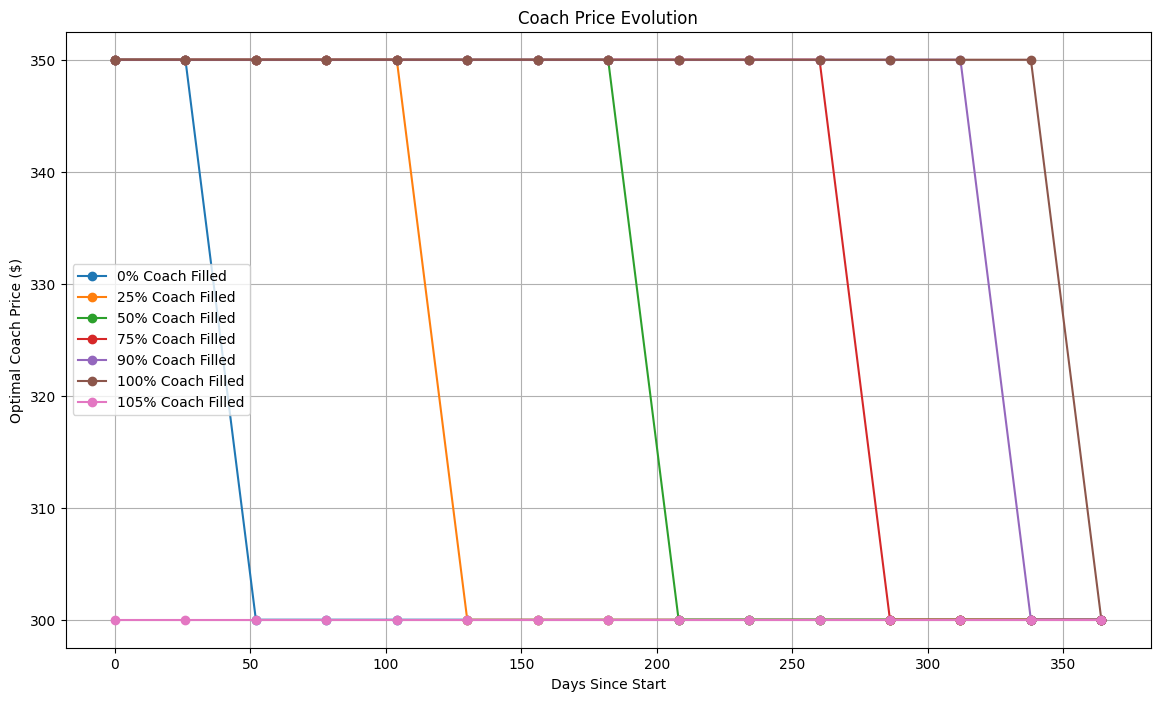

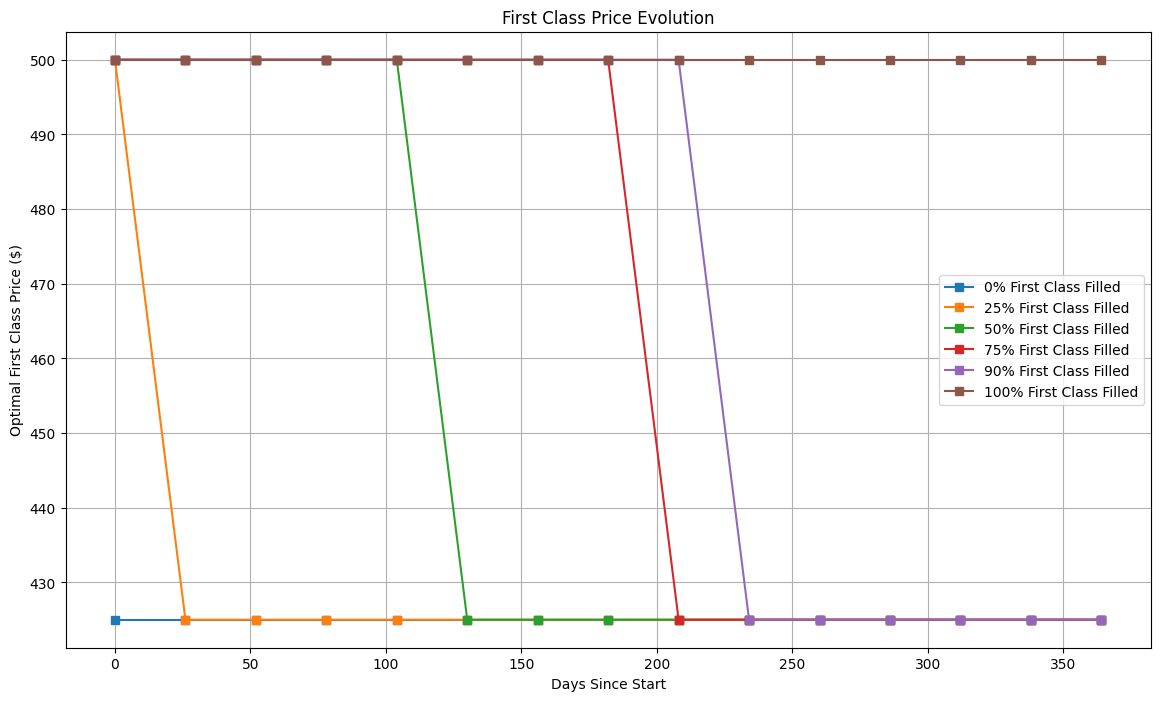

In [9]:
visualize_price_evolution(U, params, 5, has_no_sale=False)

In [ ]:
results = compare_overbooking_levels(range(5, 16), params)

# Question 3

In [ ]:
def run_dp_with_no_sale_option(params):
    coach_seats = params['coach_seats']
    first_class_seats = params['first_class_seats']
    days = params['days_until_takeoff']
    discount = get_discount_factor(params['annual_discount_rate'])

    coach_prices = params['coach_prices']
    first_class_prices = params['first_class_prices']
    coach_sale_prob = params['coach_sale_prob']
    coach_sale_prob_fc_sold_out = params['coach_sale_prob_fc_sold_out']
    first_class_sale_prob = params['first_class_sale_prob']

    #fixed value of max coach tickets
    max_coach_tickets = 120

    V = np.zeros((max_coach_tickets + 1, first_class_seats + 1, days + 1))
    U = np.zeros_like(V, dtype=int)

    # Calculate expected cost at departure
    V = calculate_terminal_costs(
        V,
        max_coach_tickets=max_coach_tickets,
        first_class_seats=first_class_seats,
        coach_show_prob=params['coach_show_prob'],
        first_class_show_prob=params['first_class_show_prob'],
        coach_seats=coach_seats,
        cost_bump_to_fc=params['cost_bump_to_first_class'],
        cost_bump_off=params['cost_bump_off_plane']
    )

    for day in range(days - 1, -1, -1):
        for cs in range(max_coach_tickets + 1):
            for fs in range(first_class_seats + 1):

                if fs == first_class_seats:
                    allowed_actions = [0 * 2 + 1, 1 * 2 + 1, 2 * 2 + 1]  # no-sale, low, high — all with FC forced to high
                else:
                    allowed_actions = range(6)  # 0 to 5

                best_value = float('-inf')
                best_action = None

                for action in allowed_actions:
                    coach_option = action // 2  # 0, 1, 2
                    fc_option = action % 2     # 0, 1

                    # Coach logic
                    if coach_option == 0:
                        p_c = 0
                        rev_c = 0
                    else:
                        price_c = coach_prices[coach_option - 1]
                        if cs < max_coach_tickets:
                            p_c = coach_sale_prob_fc_sold_out[price_c] if fs == first_class_seats else coach_sale_prob[price_c]
                        else:
                            p_c = 0
                        rev_c = price_c * p_c

                    # FC logic
                    if fs == first_class_seats:
                        price_fc = first_class_prices[1]  # Force to high
                        p_f = 0  # no sales
                    else:
                        price_fc = first_class_prices[fc_option]
                        p_f = first_class_sale_prob[price_fc]
                    rev_f = price_fc * p_f if fs < first_class_seats else 0

                    immediate_revenue = rev_c + rev_f

                    # Transition probabilities
                    prob_none = (1 - p_c) * (1 - p_f)
                    prob_c_only = p_c * (1 - p_f) if cs < max_coach_tickets else 0
                    prob_f_only = (1 - p_c) * p_f if fs < first_class_seats else 0
                    prob_both = p_c * p_f if (cs < max_coach_tickets and fs < first_class_seats) else 0

                    future_value = 0
                    future_value += prob_none * V[cs, fs, day + 1]
                    if cs < max_coach_tickets:
                        future_value += prob_c_only * V[cs + 1, fs, day + 1]
                    if fs < first_class_seats:
                        future_value += prob_f_only * V[cs, fs + 1, day + 1]
                    if cs < max_coach_tickets and fs < first_class_seats:
                        future_value += prob_both * V[cs + 1, fs + 1, day + 1]

                    current_value = immediate_revenue + discount * future_value

                    if current_value > best_value:
                        best_value = current_value
                        best_action = action

                V[cs, fs, day] = best_value
                U[cs, fs, day] = best_action

    return V, U


In [ ]:
V, U = run_dp_with_no_sale_option(params)
print(f"Expected Profit: ${V[0, 0, 0]:.2f}")

In [ ]:
# Visualize price 
visualize_price_evolution(U, params, 20, has_no_sale=True)